# Diff in Diff: Carbon Pricing and innovation in China

**Overview:**
Diff-in-Diff is a powerful tool and is commonly used to measure the effect of a reform/policy. Cui et al. (2018) study the effect of ETS (Emission Trading Scheme) on low-carbon innovation. The study will actually go further than a Diff-in-Diff and use a triple difference (an additional layer reinforcing the identification strategy).

**Setup:**
- ETS: "*Emissions trading is a market-based approach to controlling pollution by providing economic incentives for reducing the emissions of pollutants.*" Wikipedia
- ETS in this case: China implemented an ETS cap-and-trade, meaning that the government defines a total cap on $CO^2$ emission for a region. Each company receives an initial number of permits (corresponding to a quantity of emissions). If a company wants to pollute more they have to buy the permit from another.
- Spatial coverage: The 2011 pilot model in China was launched in 4 municipalities (Beijing, Chongqing, Shanghai, and Tianjin), 2 provinces (Guangdong and Hubei), and the special economic zone of Shenzhen City.
![map with ETS](./figure/Chinese-ETS.png "Chinese pilot ETS")

- This program concerns only some regions and some sectors. Hence we will be able to exploit the pre-post reform difference (first difference), but also the region differences (second difference), and additional the sector difference (third difference).

## 1. Variables selection
- **outcome:** Number of low carbon patents
- **explanatory variable:** region (pilot region or not)
- **heterogeneity:** sector (subject to ETS or not), period (pre/post).

## 2. Sample selection
We have a panel dataset company-year from 2003 to 2015 with 1956 companies.

List of main variables:
- *id:* id of the firm
- *year*
- *region:* 1 if region subjects to ETS, 0 otherwise
- *Ind:* 1 if industry subjects to ETS, 0 otherwise
- *post:* 1 for the post period, 0 otherwise
- *logenvrAEW:* log(number of low-carbon patents)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew
import seaborn as sns
import numpy as np
import linearmodels as lm
from linearmodels.panel import PanelOLS
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer

In [2]:
df = pd.read_stata("./cui_et_al.dta")
df_s = df[['id', 'year', 'region', 'Ind', 'post', 'logenvrAEW']]
df_s.head()

,id,year,region,Ind,post,logenvrAEW
0,1854.0,2003.0,1.0,0.0,0.0,0.0
1,1854.0,2004.0,1.0,0.0,0.0,0.0
2,1854.0,2005.0,1.0,0.0,0.0,0.0
3,1854.0,2006.0,1.0,0.0,0.0,0.0
4,1854.0,2007.0,1.0,0.0,0.0,0.0


In [3]:
df_s.describe()

,id,year,region,Ind,post,logenvrAEW
count,18937.000000,18824.000000,18937.000000,18937.000000,18937.000000,18937.000000
mean,991.293945,2009.903262,0.274436,0.342398,0.481280,0.290259
std,582.523499,3.543904,0.446194,0.474493,0.499659,0.712681
min,1.000000,2003.000000,0.000000,0.000000,0.000000,0.000000
25%,445.000000,2007.000000,0.000000,0.000000,0.000000,0.000000
50%,1081.000000,2010.000000,0.000000,0.000000,0.000000,0.000000
75%,1445.000000,2013.000000,1.000000,1.000000,1.000000,0.000000
max,1956.000000,2015.000000,1.000000,1.000000,1.000000,5.894403


**Note:** Some observation do not have the year. Let's drop those.

In [4]:
df_s = df_s[df_s['year'].notna()]
df_s.describe()

,id,year,region,Ind,post,logenvrAEW
count,18824.000000,18824.000000,18824.000000,18824.000000,18824.000000,18824.000000
mean,989.896423,2009.903262,0.274012,0.343073,0.478166,0.292001
std,582.949158,3.543904,0.446070,0.474748,0.499548,0.714450
min,1.000000,2003.000000,0.000000,0.000000,0.000000,0.000000
25%,442.000000,2007.000000,0.000000,0.000000,0.000000,0.000000
50%,1081.000000,2010.000000,0.000000,0.000000,0.000000,0.000000
75%,1443.000000,2013.000000,1.000000,1.000000,1.000000,0.000000
max,1956.000000,2015.000000,1.000000,1.000000,1.000000,5.894403


## 3. Univariate analysis
### 3.1 Low carbon patents
- This variable is already log transformed as it's highly asymmetric.

In [5]:
#They used the log(X+1) transformation
df_s['envrAEW'] = np.exp(df_s['logenvrAEW'])-1
df_s.describe()

,id,year,region,Ind,post,logenvrAEW,envrAEW
count,18824.000000,18824.000000,18824.000000,18824.000000,18824.000000,18824.000000,18824.000000
mean,989.896423,2009.903262,0.274012,0.343073,0.478166,0.292001,1.382278
std,582.949158,3.543904,0.446070,0.474748,0.499548,0.714450,7.916742
min,1.000000,2003.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,442.000000,2007.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1081.000000,2010.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1443.000000,2013.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,1956.000000,2015.000000,1.000000,1.000000,1.000000,5.894403,362.000061


Skewness envrAEW: 
17.26020701932449


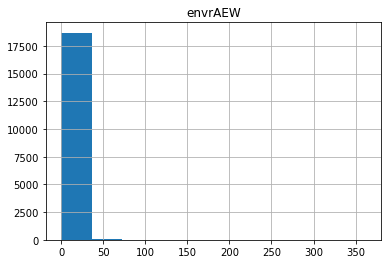

In [6]:
#histogram and skewness
df_s.hist(column='envrAEW')

print("Skewness envrAEW: ")
print(skew(df_s['envrAEW'], nan_policy='omit'))

In [8]:
#The data are so asymmetric that a table would fit better.
df_s.groupby(['envrAEW']).size().reset_index(name='counts')

,envrAEW,counts
0,0.000000,15215
1,1.000000,1097
2,2.000000,706
3,3.000000,351
4,4.000000,271
...,...,...
100,194.000031,1
101,197.000015,1
102,198.000031,1
103,253.000061,1


array([[<AxesSubplot:title={'center':'envrAEW'}>]], dtype=object)

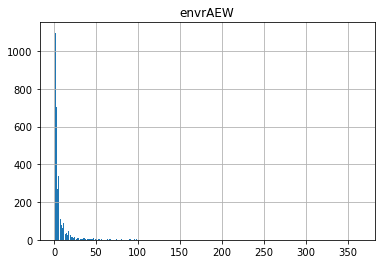

In [9]:
#104 unique values, still hard to read. So, let's play with the histogram. 
df_s[df_s['envrAEW'] > 0].hist(column='envrAEW', bins=range(1,365,1))

array([[<AxesSubplot:title={'center':'envrAEW'}>]], dtype=object)

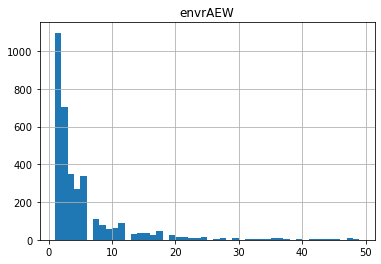

In [10]:
df_s[(df_s['envrAEW'] > 0) & (df_s['envrAEW'] < 50)].hist(column='envrAEW', bins=range(1,50,1))

**Note:** Clearly, the data are highly asymmetric with a Skewness of 17 (mean 1.38 and a median of 1). In this case we could use the log transformation (log(X+1)) as in the paper. 

Skewness logenvrAEW: 
2.944784591106004


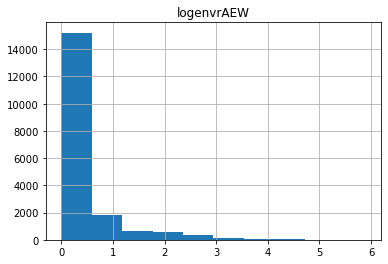

In [11]:
#histogram and skewness
df_s.hist(column='logenvrAEW')

print("Skewness logenvrAEW: ")
print(skew(df_s['logenvrAEW'], nan_policy='omit'))

**Note:** The skewness of the logged transformed data is almost 3. It remains very high.

## 4 Bivariate analysis
### 4.2 DiD (control different region same sectors)
I will not replicate the paper here. This Notebook aims to simply show you the code to implement a DiD.
Here I use only the firms from the covered sector and compare the evolution in the pilot ETS vs. outside.

In [12]:
df_mean = df_s.groupby(['year', 'region', 'Ind'])['envrAEW'].agg(['mean'])
df_mean.reset_index(inplace=True)
df_mean

,year,region,Ind,mean
0,2003.0,0.0,0.0,0.084699
1,2003.0,0.0,1.0,0.029963
2,2003.0,1.0,0.0,0.248322
3,2003.0,1.0,1.0,0.558824
4,2004.0,0.0,0.0,0.081841
5,2004.0,0.0,1.0,0.079861
6,2004.0,1.0,0.0,0.234940
7,2004.0,1.0,1.0,0.514286
8,2005.0,0.0,0.0,0.151961
9,2005.0,0.0,1.0,0.069767


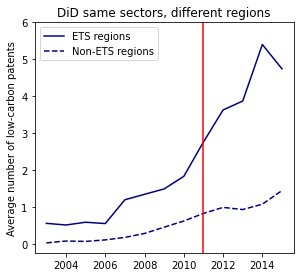

In [52]:
#Graphical representation
plt.axes([.05,.05,.6,.8])

plt.plot(df_mean[(df_mean['Ind'] == 1) & (df_mean['region'] == 1)]['year'],
         df_mean[(df_mean['Ind'] == 1) & (df_mean['region'] == 1)]['mean'],
         color = "navy",linestyle = '-', label = "ETS regions")

plt.plot(df_mean[(df_mean['Ind'] == 1) & (df_mean['region'] == 0)]['year'],
         df_mean[(df_mean['Ind'] == 1) & (df_mean['region'] == 0)]['mean'],
         color = "navy", linestyle = '--', label = "Non-ETS regions")
plt.title("DiD same sectors, different regions")
plt.xlabel("")
plt.ylabel("Average number of low-carbon patents")
plt.axvline(x=2011, ymin=0, ymax=6, color='red')
plt.yticks(range(7))
plt.legend()

plt.show()

**Note:** The evolution of low-carbon patens evolve faster in the pilot region. (It seems unlikely that the parallel trends hypothesis holds when we look at the "pre" period). 

## 5 Multivariate analysis: DiD comparing the same sectors in ETS regions vs outside
### 5.1 Simple approach

In [14]:
df_did = df.loc[df['Ind']==1]


df_did['post_region'] = df_did['post']*df_did['region']
df_did = df_did[df_did['year'].notna()]
df_did['post_region'].describe()

C:\Users\qgallea\AppData\Local\Temp\ipykernel_29792\1883768859.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_did['post_region'] = df_did['post']*df_did['region']


count    6458.000000
mean        0.101270
std         0.301706
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: post_region, dtype: float64

In [15]:
#Simplest model
reg1 = smf.wls("logenvrAEW~region+post+post_region", df_did).fit()
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:             logenvrAEW   R-squared:                       0.066
Model:                            WLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     152.4
Date:                Tue, 06 Dec 2022   Prob (F-statistic):           2.00e-95
Time:                        21:15:57   Log-Likelihood:                -6055.0
No. Observations:                6458   AIC:                         1.212e+04
Df Residuals:                    6454   BIC:                         1.215e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.1020      0.012      8.725      0.000       0.079       0.125
region          0.1105      0.025      4.335      0.000       0.061       0.160
post            0.2603      0.017     14.894      0.000       0.226       0.295
post_region     0.1361      0.037      3.633      0.000       0.063       0.209
==============================================================================
Omnibus:                     3768.709   Durbin-Watson:                   0.796
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            31758.851
Skew:                           2.747   Prob(JB):                         0.00
Kurtosis:                      12.373   Cond. No.                         6.48
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Note:** What about the errors?! We have panel data and hence at least we should use cluster standard errors. Latest research on the subject: https://academic.oup.com/qje/advance-article-abstract/doi/10.1093/qje/qjac038/6750017?redirectedFrom=fulltext

In [16]:
# Set the index for fixed effects
df_did = df_did.set_index(['id', 'year'])

In [17]:
#We will now use PanelOLS to have errors clustered at the firm level
#We need to add a variable for the intercept to force the model to have one.
df_did['one'] = 1

FE1 = PanelOLS(df_did.logenvrAEW, df_did[['one','region','post','post_region']],
              entity_effects = False,
              time_effects = False
              )

# Result
reg1 = FE1.fit(cov_type = 'clustered',
             cluster_entity=True,
             # cluster_time=True
              )

reg1

Dep. Variable:,logenvrAEW,R-squared:,0.0662
Estimator:,PanelOLS,R-squared (Between):,-0.0504
No. Observations:,6458,R-squared (Within):,0.1186
Date:,"Tue, Dec 06 2022",R-squared (Overall):,0.0662
Time:,21:19:25,Log-likelihood,-6055.0
Cov. Estimator:,Clustered,,
,,F-statistic:,152.39
Entities:,592,P-value,0.0000
Avg Obs:,10.909,Distribution:,"F(3,6454)"
Min Obs:,3.0000,,
Max Obs:,13.000,F-statistic (robust):,69.169


**Note:** The errors are significantly higher now but the effect remains statistically significant. The firms in the ETS region increases their low carbon patent submission by 13.6%.

In [18]:
#Let's compare different models
#Baseline with controls
FE2 = PanelOLS(df_did.logenvrAEW, df_did[['one','region','post','post_region','t_Revenue','t_Assets',
                                          't_CurrentLiability','t_ROA','t_EBIT']],
              entity_effects = False,
              time_effects = False
              )

# Result
reg2 = FE2.fit(cov_type = 'clustered',
             cluster_entity=True
              )

reg2

C:\Users\qgallea\Anaconda3\lib\site-packages\linearmodels\panel\model.py:1183: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Dep. Variable:,logenvrAEW,R-squared:,0.2478
Estimator:,PanelOLS,R-squared (Between):,0.3115
No. Observations:,5176,R-squared (Within):,0.1633
Date:,"Tue, Dec 06 2022",R-squared (Overall):,0.2478
Time:,21:22:36,Log-likelihood,-4279.8
Cov. Estimator:,Clustered,,
,,F-statistic:,212.76
Entities:,592,P-value,0.0000
Avg Obs:,8.7432,Distribution:,"F(8,5167)"
Min Obs:,1.0000,,
Max Obs:,13.000,F-statistic (robust):,25.015


**Note:** The sample is significantly reduced (from 6458 to 5176) due to missing data. The estimate (post_region) goes from to 0.14 to 0.17.

In [19]:
#Baseline with controls and entities fixed effects
#FE_i takes into account the constant (one) and region variable (as it's fixed over time)
FE3 = PanelOLS(df_did.logenvrAEW, df_did[['post','post_region','t_Revenue','t_Assets',
                                          't_CurrentLiability','t_ROA','t_EBIT']],
              entity_effects = True,
              time_effects = False
              )

# Result
reg3 = FE3.fit(cov_type = 'clustered',
             cluster_entity=True
              )

reg3

C:\Users\qgallea\Anaconda3\lib\site-packages\linearmodels\panel\model.py:1183: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Dep. Variable:,logenvrAEW,R-squared:,0.1692
Estimator:,PanelOLS,R-squared (Between):,-90.785
No. Observations:,5176,R-squared (Within):,0.1692
Date:,"Tue, Dec 06 2022",R-squared (Overall):,-38.649
Time:,21:22:38,Log-likelihood,-3011.1
Cov. Estimator:,Clustered,,
,,F-statistic:,133.16
Entities:,592,P-value,0.0000
Avg Obs:,8.7432,Distribution:,"F(7,4577)"
Min Obs:,1.0000,,
Max Obs:,13.000,F-statistic (robust):,32.452


**Note:** There is an important increase of the coef (from 0.17 to 0.22).

In [20]:
#Baseline with controls and entities fixed effects and year fixed effects
#FE_t takes into account the post variable (drop it)
FE4 = PanelOLS(df_did.logenvrAEW, df_did[['post_region','t_Revenue','t_Assets',
                                          't_CurrentLiability','t_ROA','t_EBIT']],
              entity_effects = True,
              time_effects = True
              )

# Result
reg4 = FE4.fit(cov_type = 'clustered',
             cluster_entity=True,
             # cluster_time=True
              )

reg4

C:\Users\qgallea\Anaconda3\lib\site-packages\linearmodels\panel\model.py:1183: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Dep. Variable:,logenvrAEW,R-squared:,0.0334
Estimator:,PanelOLS,R-squared (Between):,-55.557
No. Observations:,5176,R-squared (Within):,0.1494
Date:,"Tue, Dec 06 2022",R-squared (Overall):,-23.548
Time:,21:23:30,Log-likelihood,-2987.6
Cov. Estimator:,Clustered,,
,,F-statistic:,26.295
Entities:,592,P-value,0.0000
Avg Obs:,8.7432,Distribution:,"F(6,4566)"
Min Obs:,1.0000,,
Max Obs:,13.000,F-statistic (robust):,8.1585


**Note:** The effect survived all those tests.

### 5.2 Parallel trends test:

In [43]:
df_placebo = df_did[(df_did['post'] == 0)]
df_placebo.reset_index(inplace=True)

df_placebo.loc[df_placebo['year'] >2007,'post'] = 1
df_placebo.loc[df_placebo['year'] >2007,'post_region'] = df_placebo['post']* df_placebo['region']
df_placebo = df_placebo.set_index(['id','year'])


In [51]:

FE5 = PanelOLS(df_placebo.logenvrAEW, df_placebo[['post_region']],
              entity_effects = True,
              time_effects = True
              )

# Result
reg5 = FE5.fit(cov_type = 'clustered',
             cluster_entity=True,
             # cluster_time=True
              )

reg5

Dep. Variable:,logenvrAEW,R-squared:,0.0039
Estimator:,PanelOLS,R-squared (Between):,0.0340
No. Observations:,3539,R-squared (Within):,0.0168
Date:,"Tue, Dec 06 2022",R-squared (Overall):,0.0266
Time:,21:42:36,Log-likelihood,-849.13
Cov. Estimator:,Clustered,,
,,F-statistic:,11.673
Entities:,538,P-value,0.0006
Avg Obs:,6.5781,Distribution:,"F(1,2993)"
Min Obs:,1.0000,,
Max Obs:,8.0000,F-statistic (robust):,1.5413


In [49]:
df_placebo = df_did[(df_did['post'] == 0)]
df_placebo.reset_index(inplace=True)

df_placebo.loc[df_placebo['year'] >2006,'post'] = 1
df_placebo.loc[df_placebo['year'] >2006,'post_region'] = df_placebo['post']* df_placebo['region']
df_placebo = df_placebo.set_index(['id','year'])


In [50]:

FE6 = PanelOLS(df_placebo.logenvrAEW, df_placebo[['post_region']],
              entity_effects = True,
              time_effects = True
              )

# Result
reg6 = FE6.fit(cov_type = 'clustered',
             cluster_entity=True,
             # cluster_time=True
              )

reg6

Dep. Variable:,logenvrAEW,R-squared:,0.0039
Estimator:,PanelOLS,R-squared (Between):,0.0340
No. Observations:,3539,R-squared (Within):,0.0168
Date:,"Tue, Dec 06 2022",R-squared (Overall):,0.0266
Time:,21:42:31,Log-likelihood,-849.13
Cov. Estimator:,Clustered,,
,,F-statistic:,11.673
Entities:,538,P-value,0.0006
Avg Obs:,6.5781,Distribution:,"F(1,2993)"
Min Obs:,1.0000,,
Max Obs:,8.0000,F-statistic (robust):,1.5413


**Note:** Those two placebo tests do not discard the parrallel trend hypothesis for the "pre" period. As the coefficients on fake_treated are not statistically signficant.